In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import io
import itertools
import warnings
import statsmodels.stats.proportion

import polars as pl
pl.Config.set_tbl_rows(-1)
pl.Config.set_fmt_str_lengths(50)


from brokenaxes import brokenaxes


from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

In [5]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]

sample_id_to_group_id = {
    "PD50477f": "PD50477f",
    "PD50519d": "PD46180c_PD50519d",
    "PD50508f": "PD50508bf",
    "PD50523b": "PD50523b",
    "PD50521b": "PD50521be",
    "PD50508b": "PD50508bf",
    "PD46180c": "PD46180c_PD50519d",
    "PD50521e": "PD50521be",
    "PD50489e": "PD50489e",
}

group_id_order = [
    "PD46180c_PD50519d",
    "PD50521be",
    "PD50508bf",
    "PD50477f",
    "PD50489e",
    "PD50523b",
]

sample_id_order = [
    "PD46180c", 
    "PD50519d", 
    "PD50508b", 
    "PD50508f", 
    "PD50521b", 
    "PD50521e", 
    "PD50477f", 
    "PD50489e",
    "PD50523b", 
]

# Add relevant fields to the dataframe of all reads

## Create reads dataframe

In [6]:
%%time
reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.all_reads_structure_annotated.parquet"
    ) 
    for focal_sample_id in tqdm.tqdm(sample_ids)
    for chrom in aut_chrom_names
])

100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

CPU times: user 63.6 ms, sys: 86.6 ms, total: 150 ms
Wall time: 6.13 s


## Subset of reads with at least 5 SNPs 

In [7]:
dense_reads_df = (reads_df
    .select(
        'read_name',
        'read_length',
        'chrom',
        'sample_id',
        'grch37_chromosome_size_in_bp',
        'high_quality_snp_positions',
        "high_quality_snp_positions_alleles",
        'CO_active_interval_start',
        'CO_active_interval_end',
        'CO_active_interval_length_bp',
        'NCO_active_interval_start',
        'NCO_active_interval_end',
        'NCO_active_interval_length_bp',
        'grch37_reference_start',
        'grch38_reference_start',
        'grch37_reference_end',
        'grch38_reference_end',
        'T2T_reference_start',
        'grch37_reference_start_cM',
        'grch37_reference_end_cM',
        'CO_active_interval_start_cM',
        'CO_active_interval_end_cM',
        'CO_active_interval_crossover_prob',
        'NCO_active_interval_start_cM',
        'NCO_active_interval_end_cM',
        'NCO_active_interval_crossover_prob',
        "NCO_prob_detection_in_CO_active_interval",
        "full_read_crossover_prob",
        'AA_motif_center_pos',
        'AA_heat',
        'AA_motif_strand',
        'CL4_motif_center_pos',
        'CL4_heat',
        'CL4_motif_strand',
        'is_high_quality_read',        
    )                  
    .filter(pl.col("high_quality_snp_positions").list.len() >= 5)
    .filter("is_high_quality_read")
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)
)

## Cross with recombinant reads

In [8]:
cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])

very_trusty_cls_df = cls_df.filter(pl.col("high_quality_classification"))


### Re-call the class only on high quality SNPs, only in the active region, but use the filtering of reads to avoid problems like fake COs from low coverage etc.

In [9]:
%%time
dense_reads_with_detection_df = (dense_reads_df
    .join(
        very_trusty_cls_df.select("read_name", "class", "snp_positions_on_read", "idx_transitions").lazy(),
        on="read_name",
        how="left",
    )                  
).collect()

dense_reads_with_detection_df = (dense_reads_with_detection_df    
    .join(
        (dense_reads_with_detection_df
            .with_columns(
                high_quality_snps_diff = pl.col("high_quality_snp_positions_alleles").list.diff(null_behavior="drop"),
            )
            .with_columns(
                high_quality_snps_transitions = pl.col("high_quality_snps_diff").list.eval(pl.element() != 0).cast(pl.List(int)),        
            )
            .with_columns(
                high_quality_detected_class = pl.when( 
                    (pl.col("class").is_not_null()) &
                    (pl.col("high_quality_snp_positions_alleles").list.get(0) == pl.col("high_quality_snp_positions_alleles").list.get(1)) &
                    (pl.col("high_quality_snp_positions_alleles").list.get(-1) == pl.col("high_quality_snp_positions_alleles").list.get(-2))
                ).then(
                    pl.when(
                        pl.col("high_quality_snps_transitions").list.sum() == 1
                    ).then(
                        pl.lit("CO")
                    ).when(
                        pl.col("high_quality_snps_transitions").list.sum() == 2
                    ).then(
                        pl.lit("NCO")
                    )
                )
            )
            .select("read_name", "high_quality_detected_class")
        ),
        on="read_name",
    )        
)             

CPU times: user 1min 49s, sys: 37.6 s, total: 2min 27s
Wall time: 1min 45s


### Add annotation for CO and NCO reads only

In [10]:
CO_NCO_df = (dense_reads_with_detection_df
    .filter(pl.col("class").is_in(["CO", "GC"]))
    .with_columns(
        grch37_active_start_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch37_active_end_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch38_active_start_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch38_active_end_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
    )
    .with_columns(
        grch37_active_region_length = pl.col("grch37_active_end_pos") - pl.col("grch37_active_start_pos"),                
        grch38_active_region_length = pl.col("grch38_active_end_pos") - pl.col("grch38_active_start_pos"),                
    )
)

dfs = []
for [chrom], df in CO_NCO_df.partition_by(by=["chrom"], as_dict=True).items():
    rate_map = annotate.rate_maps[chrom]
    dfs.append(
        df.with_columns(
            grch37_active_start_poses_cm = rate_map.get_cumulative_mass(df["grch37_active_start_pos"]) * 1e2,
            grch37_active_end_poses_cm = rate_map.get_cumulative_mass(df["grch37_active_end_pos"]) * 1e2,
        ).with_columns(
            grch37_active_cM = (pl.col("grch37_active_end_poses_cm") - pl.col("grch37_active_start_poses_cm")),
            grch37_cM_per_bp_across_active = (pl.col("grch37_active_end_poses_cm") - pl.col("grch37_active_start_poses_cm")) / pl.col("grch37_active_region_length"),
        )
    )
    
CO_NCO_df = pl.concat(dfs)

# Differences in genetic lengths

## Different chromosomes and samples?

In [11]:
def test_condition(condition):
    df = (dense_reads_with_detection_df
        .filter(condition)
        .filter(pl.col("high_quality_detected_class").is_not_null())
        .select(
            "CO_active_interval_crossover_prob",
            "high_quality_detected_class",
        )
    )

    CO_lens = df.filter(pl.col("high_quality_detected_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
    NCO_lens = df.filter(pl.col("high_quality_detected_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
    
    return len(CO_lens), len(NCO_lens), scipy.stats.ks_2samp(CO_lens, NCO_lens).pvalue, inference.permutation_testing([[CO_lens, NCO_lens]], 1000)

In [12]:
rows = []
for chrom in tqdm.tqdm(aut_chrom_names):
    rows.append([chrom] + list(test_condition(pl.col("chrom") == chrom)))
    
with pl.Config(tbl_rows=100) as cfg:
    display(pl.DataFrame(rows, schema=["chrom", "n_events_CO", "n_events_NCO", "KS_pvalue", "AD_perm_pvalue"]))

100%|██████████| 22/22 [00:11<00:00,  1.90it/s]


chrom,n_events_CO,n_events_NCO,KS_pvalue,AD_perm_pvalue
str,i64,i64,f64,f64
"""chr1""",94,29,0.001704,0.0
"""chr2""",92,24,0.000138,0.0
"""chr3""",84,24,0.002545,0.0
"""chr4""",70,23,0.622119,0.438
"""chr5""",64,21,0.923463,0.722
"""chr6""",81,16,0.177059,0.054
"""chr7""",74,15,0.115624,0.036
"""chr8""",62,18,0.000009,0.0
"""chr9""",51,23,0.040434,0.017


In [13]:
rows = []
for sample_id in tqdm.tqdm(sorted(sample_ids)):
    rows.append([sample_id] + list(test_condition(pl.col("sample_id") == sample_id)))
    
with pl.Config(tbl_rows=100) as cfg:
    display(pl.DataFrame(rows, schema=["sample_id", "n_events_CO", "n_events_NCO", "KS_pvalue", "AD_perm_pvalue"]))    

100%|██████████| 9/9 [00:04<00:00,  1.84it/s]


sample_id,n_events_CO,n_events_NCO,KS_pvalue,AD_perm_pvalue
str,i64,i64,f64,f64
"""PD46180c""",206,43,0.000004,0.0
"""PD50477f""",149,32,0.001033,0.0
"""PD50489e""",132,16,0.027498,0.001
"""PD50508b""",126,29,0.000149,0.0
"""PD50508f""",103,17,0.011237,0.002
"""PD50519d""",126,43,0.000014,0.0
"""PD50521b""",185,58,0.000297,0.0
"""PD50521e""",145,35,0.323268,0.333
"""PD50523b""",158,60,0.862682,0.976


### See visually

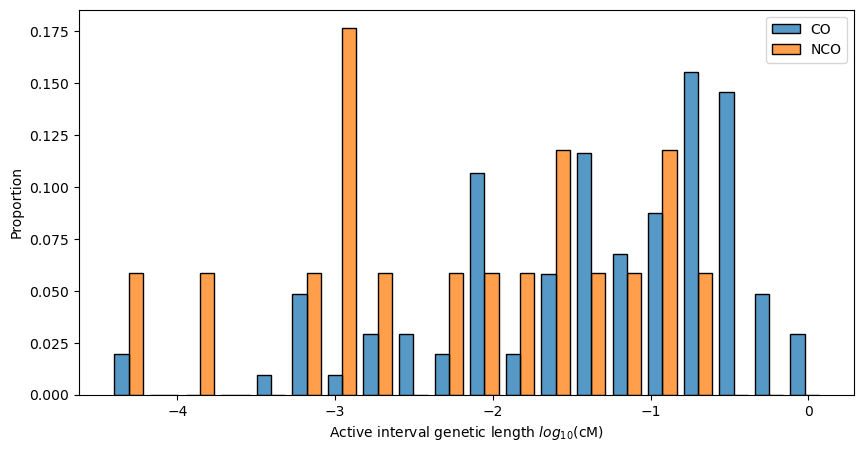

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

sample_id = "PD50508f"

df = (dense_reads_with_detection_df
    .filter(pl.col("sample_id") == sample_id)
    .filter(pl.col("high_quality_detected_class").is_not_null())
    .select(
        "CO_active_interval_crossover_prob",
        "high_quality_detected_class",
    )
)
CO_lens = df.filter(pl.col("high_quality_detected_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
NCO_lens = df.filter(pl.col("high_quality_detected_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
    

sns.histplot(
    [
        pd.Series(np.log10(CO_lens), name="CO"),
        pd.Series(np.log10(NCO_lens), name="NCO"),
    ], 
    bins=20, 
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Active interval genetic length $log_{10}$(cM)");


# DSBs

## Compare distance to motif distributions, CO vs. NCO

### Overall

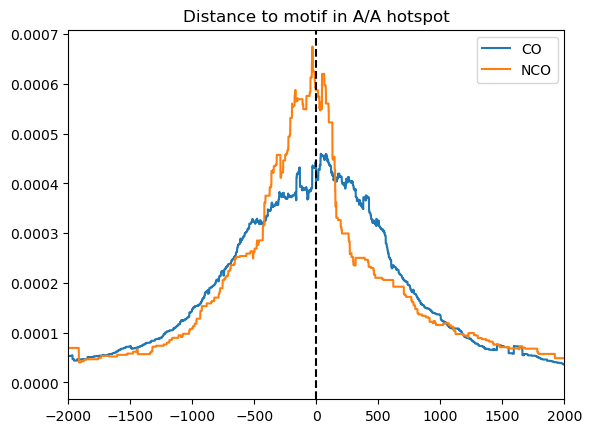

In [15]:
xs, H_CO = inference.calculate_motif_distance_histogram(
    (CO_NCO_df
        .filter(pl.col("high_quality_detected_class") == "CO")
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
)

xs, H_NCO = inference.calculate_motif_distance_histogram(
    (CO_NCO_df
        .filter(pl.col("high_quality_detected_class") == "NCO")
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
)


plt.plot(xs, H_CO, label="CO");
plt.plot(xs, H_NCO, label="NCO");
plt.title("Distance to motif in A/A hotspot");
plt.xlim(-2000,2000);
plt.axvline(0, color="black", ls="--");
plt.legend();

In [16]:
inference.motif_distance_histogram_diffs_permutation_testing(
    (CO_NCO_df
        .filter(pl.col("high_quality_detected_class") == "CO")
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    (CO_NCO_df
         .filter(pl.col("high_quality_detected_class") == "NCO")
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
    max_dist=30000,
    n_perms=1000,
    stat="sum_abs",
)

0.014

### Per sample

In [17]:
rows = []
for sample_id in tqdm.tqdm(sample_id_order):
    pval = inference.motif_distance_histogram_diffs_permutation_testing(
        (CO_NCO_df
            .filter(pl.col("high_quality_detected_class") == "CO")
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id))
        ),
        (CO_NCO_df
            .filter(pl.col("high_quality_detected_class") == "NCO")
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id))
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
        max_dist=30000,
        n_perms=1000,
        stat="sum_abs",
    )
    
    rows.append(
        [
            sample_id, 
            pval,
        ]
    )
    
motif_dists_co_vs_nco_df = pl.DataFrame(
    rows,
    schema=[
        "sample_id", 
        "perm_pval"
    ],
)       

100%|██████████| 9/9 [00:20<00:00,  2.29s/it]


In [18]:
motif_dists_co_vs_nco_df.sort("perm_pval")

sample_id,perm_pval
str,f64
"""PD50508b""",0.128
"""PD50489e""",0.156
"""PD50519d""",0.178
"""PD50477f""",0.215
"""PD46180c""",0.365
"""PD50523b""",0.475
"""PD50521e""",0.508
"""PD50521b""",0.7
"""PD50508f""",0.973


# Compare DSB signal strengths between CO and NCO

## Overall

In [46]:
heats_CO = (CO_NCO_df
    .filter(pl.col("grch38_reference_start").is_not_null())            
    .filter(pl.col("high_quality_detected_class") == "CO")
)["AA_heat"].fill_null(0).to_numpy()

heats_NCO = (CO_NCO_df
    .filter(pl.col("grch38_reference_start").is_not_null())             
    .filter(pl.col("high_quality_detected_class") == "NCO")
)["AA_heat"].fill_null(0).to_numpy()

5.121862369007926e-05 0.0 0.623 2.304295644769393e-06


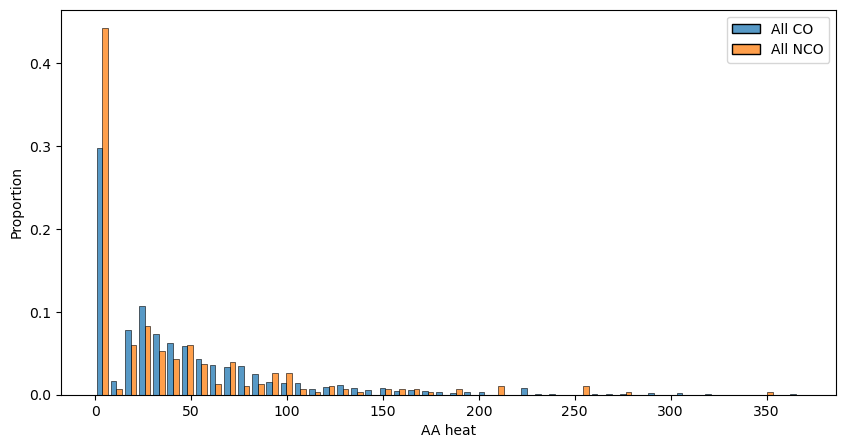

In [47]:
fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(
    [
        pd.Series(heats_CO, name="All CO"),
        pd.Series(heats_NCO, name="All NCO"),
    ], 
    bins=50, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("AA heat");
#plt.title(f"AD perm pval = {pval}");

print(
    scipy.stats.ks_2samp(heats_CO, heats_NCO).pvalue,
    inference.permutation_testing([[heats_CO, heats_NCO]], 1000),
    inference.permutation_testing([[heats_CO[heats_CO>0], heats_NCO[heats_NCO>0]]], 1000),
    scipy.stats.fisher_exact(
        [[(heats_CO==0).sum(), (heats_CO!=0).sum()],
         [(heats_NCO==0).sum(), (heats_NCO!=0).sum()]],
    ).pvalue,
)

## Per sample

In [48]:
rows = []
for sample_id in tqdm.tqdm(sample_id_order):
    heats_CO = (CO_NCO_df
        .filter(pl.col("grch38_reference_start").is_not_null())                
        .filter(pl.col("high_quality_detected_class") == "CO")
        .filter((pl.col("sample_id") == sample_id))
    )["AA_heat"].fill_null(0).to_numpy()

    heats_NCO = (CO_NCO_df
        .filter(pl.col("grch38_reference_start").is_not_null())                 
        .filter(pl.col("high_quality_detected_class") == "NCO")
        .filter((pl.col("sample_id") == sample_id))
    )["AA_heat"].fill_null(0).to_numpy()
    
    rows.append(
        [
            sample_id, 
            len(heats_CO), 
            len(heats_NCO),
            (heats_CO == 0).sum(),
            (heats_NCO == 0).sum(),
            scipy.stats.ks_2samp(heats_CO, heats_NCO).pvalue,
            inference.permutation_testing([[heats_CO, heats_NCO]], 1000),
            inference.permutation_testing([[heats_CO[heats_CO>0], heats_NCO[heats_NCO>0]]], 1000),
            scipy.stats.fisher_exact(
                [[(heats_CO==0).sum(), (heats_CO!=0).sum()],
                 [(heats_NCO==0).sum(), (heats_NCO!=0).sum()]],
            ).pvalue,
        ]
    )
    
AA_heats_co_vs_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id", "n_CO", "n_NCO", "n_CO_zeros", "n_NCO_zeros",
            "heats_ks_pvalue", 
            "heats_AD_perm_pvalue", 
            "heats_AD_perm_no_zeros_pvalue",
            "heats_fisher_pvalue",
           ],
)    

100%|██████████| 9/9 [00:03<00:00,  2.99it/s]


In [49]:
AA_heats_co_vs_nco_df.sort("heats_AD_perm_pvalue")

sample_id,n_CO,n_NCO,n_CO_zeros,n_NCO_zeros,heats_ks_pvalue,heats_AD_perm_pvalue,heats_AD_perm_no_zeros_pvalue,heats_fisher_pvalue
str,i64,i64,i64,i64,f64,f64,f64,f64
"""PD50508b""",123,29,18,13,0.020912,0.007,0.518,0.001346
"""PD46180c""",206,38,45,18,0.02462,0.011,0.211,0.002033
"""PD50519d""",124,41,32,18,0.056906,0.021,0.322,0.032952
"""PD50489e""",130,13,44,9,0.08351,0.03,0.86,0.016286
"""PD50477f""",145,30,32,13,0.097615,0.077,0.654,0.021444
"""PD50523b""",157,56,87,25,0.369273,0.145,0.794,0.212297
"""PD50521b""",182,46,52,17,0.241406,0.148,0.071,0.284489
"""PD50508f""",100,16,26,6,0.397409,0.342,0.415,0.372295
"""PD50521e""",143,32,54,14,0.932965,0.843,0.591,0.552086


# Telomere distances

In [23]:
telomere_cutoff = 20e6
telomere_step = 1e6

# Look at p and q arm separately

# p arm, exclude acrocentric chroms
acrocentric_chroms = ["chr13", "chr14", "chr15", "chr21", "chr22"]
p_arm_distances = (CO_NCO_df
    .select(
        "read_name",
        dist_from_p_telomere = pl.when(
            ~pl.col("chrom").is_in(acrocentric_chroms)  
        ).then(
           pl.col("T2T_reference_start") + pl.col("read_length")//2
        )
    )
)

# q arm, all chroms
q_arm_distances = (CO_NCO_df
    .join(
        pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "T2T_chrom_length"]),
        on="chrom",
    )
    .select(
        "read_name",
        dist_from_q_telomere = pl.col("T2T_chrom_length") - (pl.col("T2T_reference_start") + pl.col("read_length")//2),
    )
)

In [24]:
close_to_telomeres_df = (CO_NCO_df
    .join(p_arm_distances, on="read_name")
    .join(q_arm_distances, on="read_name")
    .with_columns(
        distance_to_telomere = pl.min_horizontal("dist_from_p_telomere", "dist_from_q_telomere")
    )
    .filter(pl.col("distance_to_telomere") < telomere_cutoff)
)

In [25]:
high_qual_CO_telomere_exp_probs = (close_to_telomeres_df
    .group_by(
        pl.col("distance_to_telomere") // telomere_step
    )
    .agg(
        pl.col("CO_active_interval_crossover_prob").mean().alias("prob")
    )
    .sort("distance_to_telomere")
)["prob"]

high_qual_CO_telomere_exp_freqs = high_qual_CO_telomere_exp_probs / high_qual_CO_telomere_exp_probs.sum()


high_qual_NCO_telomere_exp_probs = (close_to_telomeres_df
    .group_by(
        pl.col("distance_to_telomere") // telomere_step
    )
    .agg(
        (pl.col("NCO_active_interval_crossover_prob") * pl.col("NCO_prob_detection_in_CO_active_interval")).mean().alias("prob")
    )
    .sort("distance_to_telomere")
)["prob"]

high_qual_NCO_telomere_exp_freqs = high_qual_NCO_telomere_exp_probs / high_qual_NCO_telomere_exp_probs.sum()

In [26]:
bins = np.arange(0, telomere_cutoff + telomere_step, telomere_step)

high_qual_CO_telomere_counts = np.histogram(
    close_to_telomeres_df.filter(pl.col("high_quality_detected_class") == "CO")["distance_to_telomere"],
    bins=bins,
)[0]

high_qual_CO_telomere_freqs = high_qual_CO_telomere_counts / high_qual_CO_telomere_counts.sum()


high_qual_NCO_telomere_counts = np.histogram(
    close_to_telomeres_df.filter(pl.col("high_quality_detected_class") == "NCO")["distance_to_telomere"],
    bins=bins,
)[0]

high_qual_NCO_telomere_freqs = high_qual_NCO_telomere_counts / high_qual_NCO_telomere_counts.sum()



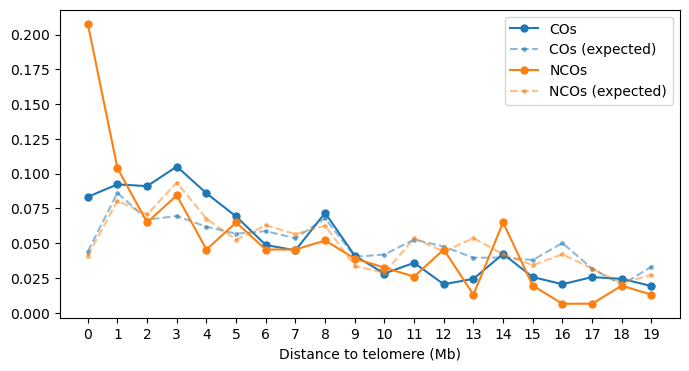

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(bins[:-1], high_qual_CO_telomere_freqs, '.-', label="COs", ms=10, color="C0")
ax.plot(bins[:-1], high_qual_CO_telomere_exp_freqs, '.--', label="COs (expected)", ms=5, color="C0", alpha=0.5)

ax.plot(bins[:-1], high_qual_NCO_telomere_freqs, '.-', label="NCOs", ms=10, color="C1")
ax.plot(bins[:-1], high_qual_NCO_telomere_exp_freqs, '.--', label="NCOs (expected)", ms=5, color="C1", alpha=0.5)
ax.legend();

ax.set_xticks(
    bins[:-1],
    labels = [f"{int(x/1e6)}" for x in bins[:-1]],
);

ax.set_xlabel("Distance to telomere (Mb)");


### Fisher exact each bin

In [28]:
pl.DataFrame(
    [
        [
            i,
            scipy.stats.fisher_exact(
                [[x, high_qual_CO_telomere_counts.sum() - x],
                 [y, high_qual_NCO_telomere_counts.sum() - y],
                ]
            ).pvalue,
        ]
        for i, (x, y) in enumerate(zip(high_qual_CO_telomere_counts, high_qual_NCO_telomere_counts))
    ],
    schema=["distance_in_Mb", "fisher_exact_pval"]
)

distance_in_Mb,fisher_exact_pval
i64,f64
0,0.000019
1,0.651197
2,0.348709
3,0.559125
4,0.102493
5,1.0
6,1.0
7,1.0
8,0.484886


### Average detection probs

In [29]:
full_reads_CO_detection_probs_df = (close_to_telomeres_df
    .group_by(
        pl.col("distance_to_telomere") // telomere_step
    )
    .agg(
        (pl.col("CO_active_interval_crossover_prob") / pl.col("full_read_crossover_prob")).mean().alias("prob")
    )
    .sort("distance_to_telomere")
)

full_reads_NCO_detection_probs_df = (close_to_telomeres_df
    .group_by(
        pl.col("distance_to_telomere") // telomere_step
    )
    .agg(
        (pl.col("NCO_prob_detection_in_CO_active_interval") * pl.col("CO_active_interval_crossover_prob") / pl.col("full_read_crossover_prob")).mean().alias("prob")
    )
    .sort("distance_to_telomere")
)

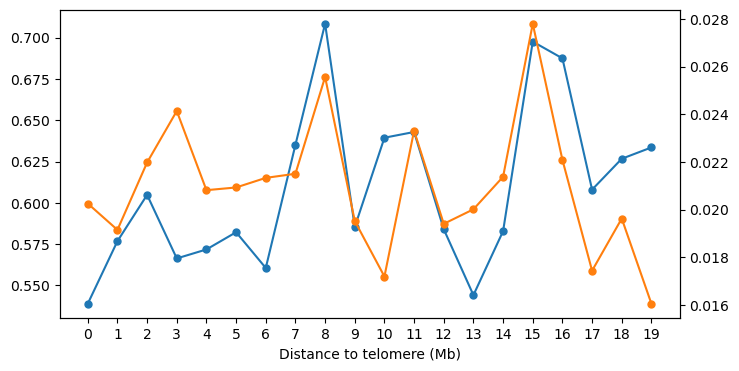

In [30]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    full_reads_CO_detection_probs_df["distance_to_telomere"],
    full_reads_CO_detection_probs_df["prob"],
    '.-', ms=10, color="C0"
)

ax2 = ax.twinx() 

ax2.plot(
    full_reads_NCO_detection_probs_df["distance_to_telomere"],
    full_reads_NCO_detection_probs_df["prob"],
    '.-', ms=10, color="C1"
)

ax.set_xticks(
    np.arange(telomere_cutoff / telomere_step),
    labels = [f"{int(x/1e6)}" for x in bins[:-1]],
);

ax.set_xlabel("Distance to telomere (Mb)");


# Correlation between distance to telomere and heat?

In [31]:
AA_hotspots_df = (
    pl.read_csv(
        "/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/06.hotspots/hinch_2023_AA_hotspots.csv",
        null_values="NA",
    ).rename({
        "Chromosome": "chrom", 
        "Motif_Centre_Pos": "motif_center_pos",
        "Start_Pos": "hotspot_start_pos",
        "End_Pos": "hotspot_end_pos",    
    })
    .sort("motif_center_pos")
    .set_sorted("motif_center_pos")
)

In [32]:
heat_baseline_df = (AA_hotspots_df
    .filter(pl.col("motif_center_pos") < telomere_cutoff)
    .select(
        (pl.col("motif_center_pos") // (telomere_step/1)).alias("distance_to_telomere"),
        "heat",
    )
    .group_by("distance_to_telomere")
    .agg(pl.col("heat").mean())
    .sort("distance_to_telomere")
)

In [33]:
emp_CO_heat_df = (close_to_telomeres_df
    .select("distance_to_telomere", "AA_heat", "high_quality_detected_class")
    .filter(pl.col("high_quality_detected_class") == "CO")
    .drop_nulls() 
    .group_by(pl.col("distance_to_telomere") // telomere_step)
    .agg(pl.col("AA_heat").mean())
    .sort("distance_to_telomere")
)

emp_NCO_heat_df = (close_to_telomeres_df
    .select("distance_to_telomere", "AA_heat", "high_quality_detected_class")
    .filter(pl.col("high_quality_detected_class") == "NCO")
    .drop_nulls() 
    .group_by(pl.col("distance_to_telomere") // telomere_step)
    .agg(pl.col("AA_heat").mean())
    .sort("distance_to_telomere")
)

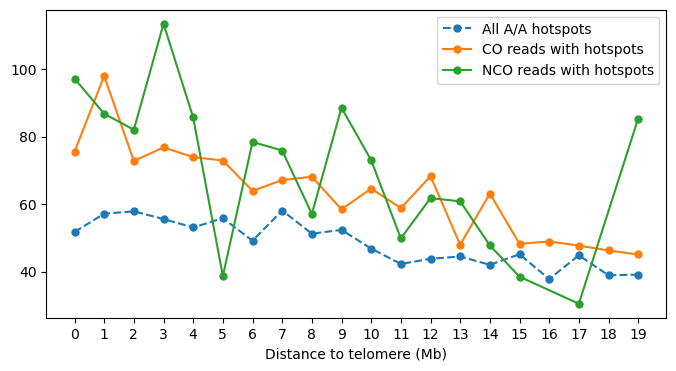

In [34]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    heat_baseline_df["distance_to_telomere"],
    heat_baseline_df["heat"],
    '.--',
    ms=10,
    label="All A/A hotspots",
);

ax.plot(
    emp_CO_heat_df["distance_to_telomere"],
    emp_CO_heat_df["AA_heat"],
    '.-',
    ms=10,
    label="CO reads with hotspots",
);

ax.plot(
    emp_NCO_heat_df["distance_to_telomere"],
    emp_NCO_heat_df["AA_heat"],
    '.-',
    ms=10,
    label="NCO reads with hotspots",
);

ax.legend();
ax.set_xticks(
    np.arange(len(bins)-1),
    labels = [f"{int(x/1e6)}" for x in bins[:-1]],
);

ax.set_xlabel("Distance to telomere (Mb)");


# Is signal driven by NCOs in last 1Mb?

## How much of them are in the last 1Mb?

In [35]:
df = (close_to_telomeres_df
    .filter(pl.col("high_quality_detected_class") == "NCO")
    .filter(pl.col("distance_to_telomere") < 1e6)
)

n_ncos_near_telomere = len(df)
ncos_near_telomere_read_names = df["read_name"]

display(df.group_by("sample_id").len())

sample_id,len
str,u32
"""PD50508b""",2
"""PD50521b""",12
"""PD50508f""",2
"""PD50521e""",4
"""PD50489e""",1
"""PD50519d""",4
"""PD50477f""",3
"""PD46180c""",1
"""PD50523b""",3


In [36]:
n_ncos_total = len(dense_reads_with_detection_df.filter(pl.col("high_quality_detected_class") == "NCO"))

In [37]:
print(n_ncos_near_telomere, n_ncos_total, n_ncos_near_telomere / n_ncos_total)

32 333 0.0960960960960961


## Are cM differences driven by last 1Mb?

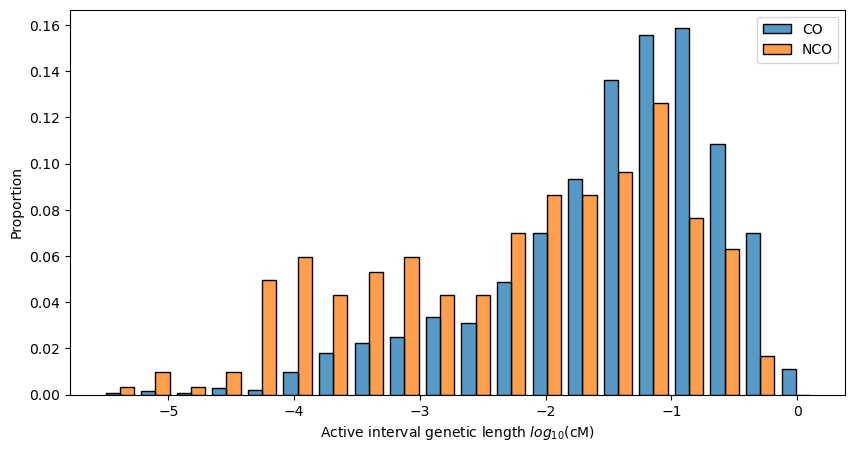

In [38]:
fig, ax = plt.subplots(figsize=(10,5))

df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_detected_class").is_not_null())
    .select(
        "read_name",
        "CO_active_interval_crossover_prob",
        "high_quality_detected_class",
    )
)
CO_lens = df.filter(pl.col("high_quality_detected_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
NCO_lens = (df
    .filter(pl.col("high_quality_detected_class") == "NCO")
    .filter(~pl.col("read_name").is_in(ncos_near_telomere_read_names))
)["CO_active_interval_crossover_prob"] * 1e2
    

sns.histplot(
    [
        pd.Series(np.log10(CO_lens), name="CO"),
        pd.Series(np.log10(NCO_lens), name="NCO"),
    ], 
    bins=20, 
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Active interval genetic length $log_{10}$(cM)");


## Genetic lengths between samples

In [39]:
sample_id_to_active_interval_lengths = {}

for sample_id in sample_ids:
    sdf = (dense_reads_with_detection_df
        .filter((pl.col("sample_id") == sample_id) & (pl.col("high_quality_detected_class") == "NCO"))
        .filter(~pl.col("read_name").is_in(ncos_near_telomere_read_names))
    )
    lens = sdf["CO_active_interval_crossover_prob"] * 1e2
    
    sample_id_to_active_interval_lengths[sample_id] = lens.to_numpy()

rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    lens_1 = sample_id_to_active_interval_lengths[sample_id1]
    lens_2 = sample_id_to_active_interval_lengths[sample_id2]
    rows.append(
        [
            sample_id1, 
            sample_id2,
            len(lens_1), 
            len(lens_2),
            scipy.stats.ks_2samp(lens_1, lens_2).pvalue,
            inference.permutation_testing([[lens_1, lens_2]], 1000),
        ]
    )
    
pairwise_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "n1", "n2", 
            "lens_ks_pvalue", 
            "lens_AD_perm_pvalue", ],
)    

100%|██████████| 36/36 [00:07<00:00,  4.85it/s]


In [40]:
pairwise_nco_df.sort("lens_AD_perm_pvalue")

sample_id1,sample_id2,n1,n2,lens_ks_pvalue,lens_AD_perm_pvalue
str,str,i64,i64,f64,f64
"""PD50519d""","""PD50523b""",39,57,0.005159,0.006
"""PD50489e""","""PD50523b""",15,57,0.106072,0.047
"""PD50508b""","""PD50519d""",27,39,0.072163,0.061
"""PD50519d""","""PD50521e""",39,31,0.059906,0.067
"""PD50489e""","""PD50521e""",15,31,0.102607,0.072
"""PD50489e""","""PD50508b""",15,27,0.120336,0.075
"""PD50521b""","""PD50523b""",46,57,0.152099,0.116
"""PD46180c""","""PD50519d""",42,39,0.071001,0.13
"""PD50477f""","""PD50523b""",29,57,0.322418,0.174


### Sample vs. rest

In [41]:
rows = []
for sample_id in tqdm.tqdm(sample_id_order):
    pairs = [
        [
            sample_id_to_active_interval_lengths[sample_id],
            sample_id_to_active_interval_lengths[other_sample_id],
        ]
        for other_sample_id in sample_ids if other_sample_id != sample_id 
    ]
    lens_1 = sample_id_to_active_interval_lengths[sample_id]
    rows.append(
        [
            sample_id, 
            len(lens_1), 
            inference.permutation_testing(pairs, 1000),
        ]
    )
    
sample_vs_rest_df = pl.DataFrame(
    rows,
    schema=["sample_id", "n_in_sample", "AD_perm_pvalue"],
)

100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


In [42]:
sample_vs_rest_df.sort("AD_perm_pvalue")

sample_id,n_in_sample,AD_perm_pvalue
str,i64,f64
"""PD50519d""",39,0.009
"""PD50523b""",57,0.033
"""PD50508b""",27,0.089
"""PD50489e""",15,0.122
"""PD50521e""",31,0.262
"""PD50521b""",46,0.605
"""PD46180c""",42,0.664
"""PD50477f""",29,0.763
"""PD50508f""",15,0.968


## Group level

In [43]:
group_id_to_active_interval_lengths = {}

for group_id in group_id_order:
    group_id_to_active_interval_lengths[group_id] = np.concatenate([
        sample_id_to_active_interval_lengths[sample_id]
        for sample_id, v in sample_id_to_group_id.items() if v == group_id
    ])

In [44]:
rows = []
for group_id in tqdm.tqdm(sorted(group_id_order)):
    pairs = [
        [
            group_id_to_active_interval_lengths[group_id],
            group_id_to_active_interval_lengths[other_group_id],
        ]
        for other_group_id in group_id_order if other_group_id != group_id 
    ]
    lens_1 = group_id_to_active_interval_lengths[group_id]
    rows.append(
        [
            group_id, 
            len(lens_1), 
            inference.permutation_testing(pairs, 1000),
        ]
    )
    
group_vs_rest_df = pl.DataFrame(
    rows,
    schema=["group_id", "n_in_group", "AD_perm_pvalue"],
)

100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


In [45]:
group_vs_rest_df.sort("AD_perm_pvalue")

group_id,n_in_group,AD_perm_pvalue
str,i64,f64
"""PD50523b""",57,0.024
"""PD50489e""",15,0.103
"""PD50508bf""",42,0.158
"""PD46180c_PD50519d""",81,0.159
"""PD50521be""",77,0.38
"""PD50477f""",29,0.666
